In [26]:
from google.colab import files
uploaded = files.upload()

Saving Countrywide ICT Survey Database.xlsx to Countrywide ICT Survey Database (1).xlsx


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

from xgboost import XGBClassifier
import shap

In [28]:
df = pd.read_excel("Countrywide ICT Survey Database.xlsx", engine="openpyxl")

print("Original Shape:", df.shape)
df.head()

Original Shape: (30239, 108)


,Device ID,Record ID,GPS coordinates (N),GPS coordinates (E),Category,District,DS Division,Name of the GN division,Name of the village,1. Serial Number,...,Government Semi-government,Income (Rs./month),Private Company,Income (Rs./month).1,Training Institute,Income (Rs./month).2,Selfemployed (eg. hardware repair),Income (Rs./month).3,Freelance Cyber worker,Income (Rs./month).4
0,864799000000000,1495780000000,6.907894,79.871946,Urban,Kandy,Akurana,Deegala - 576,deegala,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,864799000000000,1495780000000,6.907894,79.871946,Urban,Kandy,Akurana,Deegala - 576,deegala,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,864799000000000,1495780000000,6.907894,79.871946,Urban,Kandy,Akurana,Deegala - 576,deegala,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,864799000000000,1495780000000,6.910132,79.872209,Urban,Kalutara,Beruwala,Munhena - 745,munhena,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,864799000000000,1495780000000,6.910132,79.872209,Urban,Kalutara,Beruwala,Munhena - 745,munhena,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# Keep only useful columns
selected_columns = [
    "Category",   # Urban/Rural
    "District",
    "4. Sex",
    "5. Age(as at last birthday)",
    "9. Level of education",
    "10. Employment status",
    "Smart phones_Home",
    "Laptop_Home",
    "Internet_Home"   # TARGET
]

df = df[selected_columns]

In [30]:
df = df.dropna()

print("After cleaning:", df.shape)

After cleaning: (18830, 9)


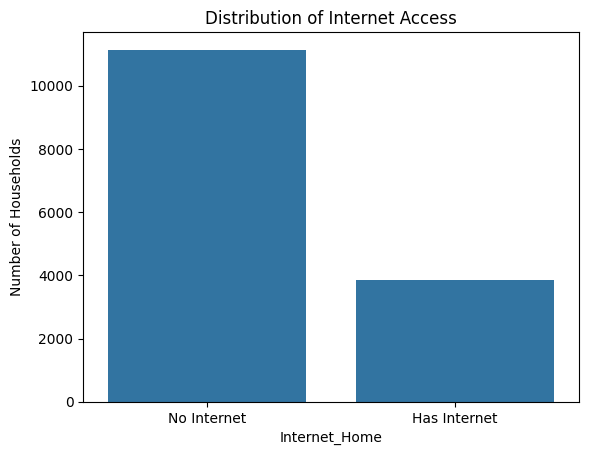

In [45]:
sns.countplot(x=df["Internet_Home"])
plt.title("Distribution of Internet Access")
plt.xticks([0,1], ["No Internet", "Has Internet"])
plt.ylabel("Number of Households")
plt.show()

In [46]:
df = df.sample(n=15000, random_state=42)
print("Reduced Shape:", df.shape)

Reduced Shape: (15000, 9)


In [47]:
le = LabelEncoder()

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])

In [48]:
X = df.drop("Internet_Home", axis=1)
y = df["Internet_Home"]

In [49]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Training size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)

Training size: (10500, 8)
Validation size: (2250, 8)
Test size: (2250, 8)


In [50]:
model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [51]:
val_pred = model.predict(X_val)
val_prob = model.predict_proba(X_val)[:,1]

print("Validation Accuracy:", accuracy_score(y_val, val_pred))
print("Validation F1:", f1_score(y_val, val_pred))
print("Validation AUC:", roc_auc_score(y_val, val_prob))

Validation Accuracy: 0.876
Validation F1: 0.7669172932330827
Validation AUC: 0.9286134627297129


In [52]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1 Score:", f1_score(y_test, y_pred))
print("Test AUC Score:", roc_auc_score(y_test, y_prob))

Test Accuracy: 0.8835555555555555
Test F1 Score: 0.7790893760539629
Test AUC Score: 0.9375494181449474


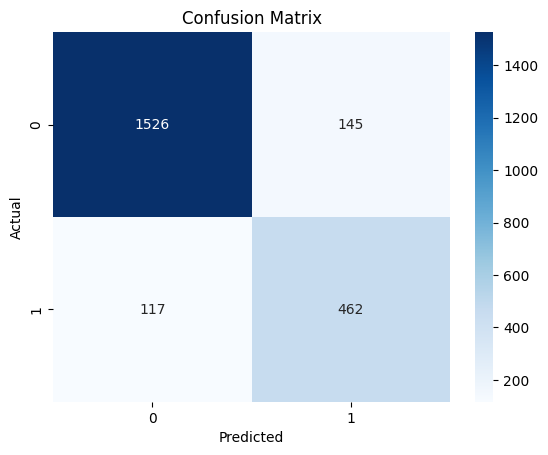

In [53]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

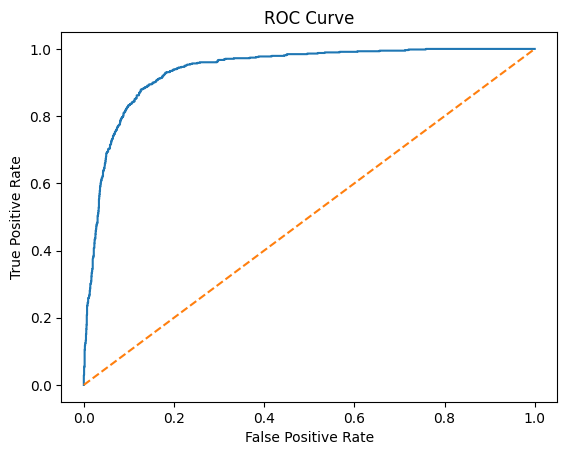

In [54]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [55]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 88.36%


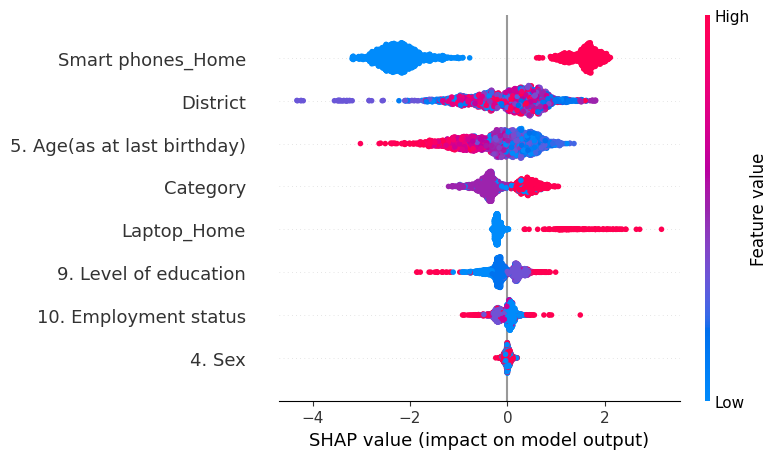

In [57]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

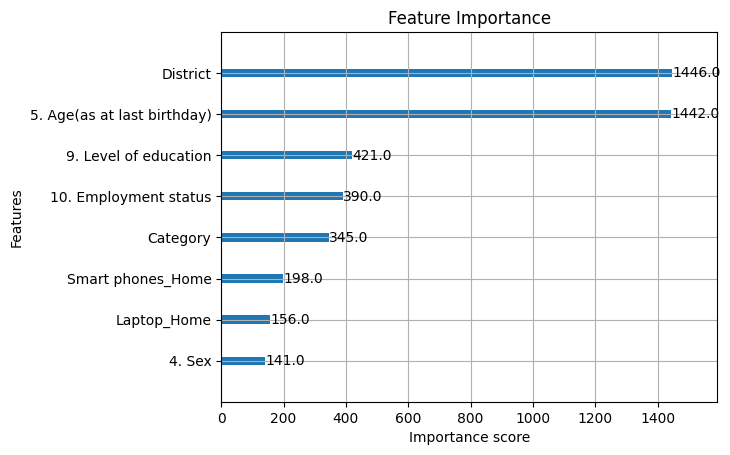

In [58]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(model)
plt.title("Feature Importance")
plt.show()

In [59]:
import joblib

joblib.dump(model, "internet_model.pkl")

['internet_model.pkl']

In [60]:
from google.colab import files
files.download("internet_model.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>